Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


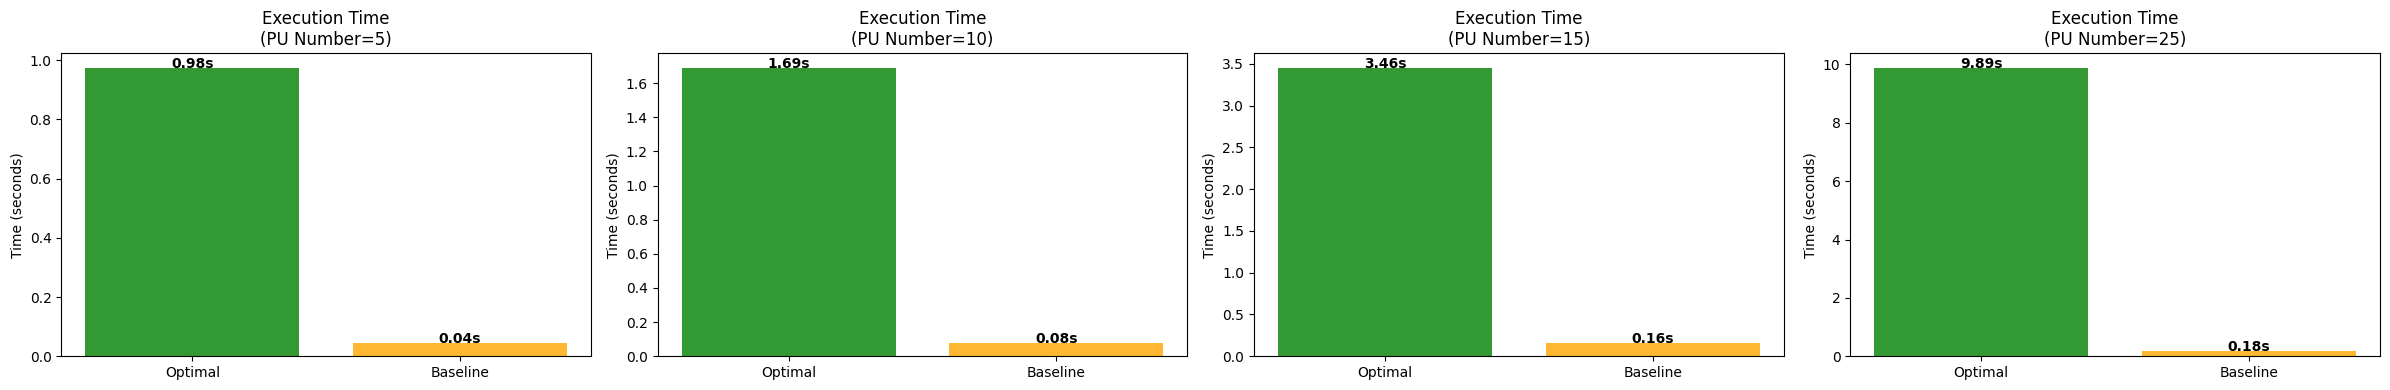

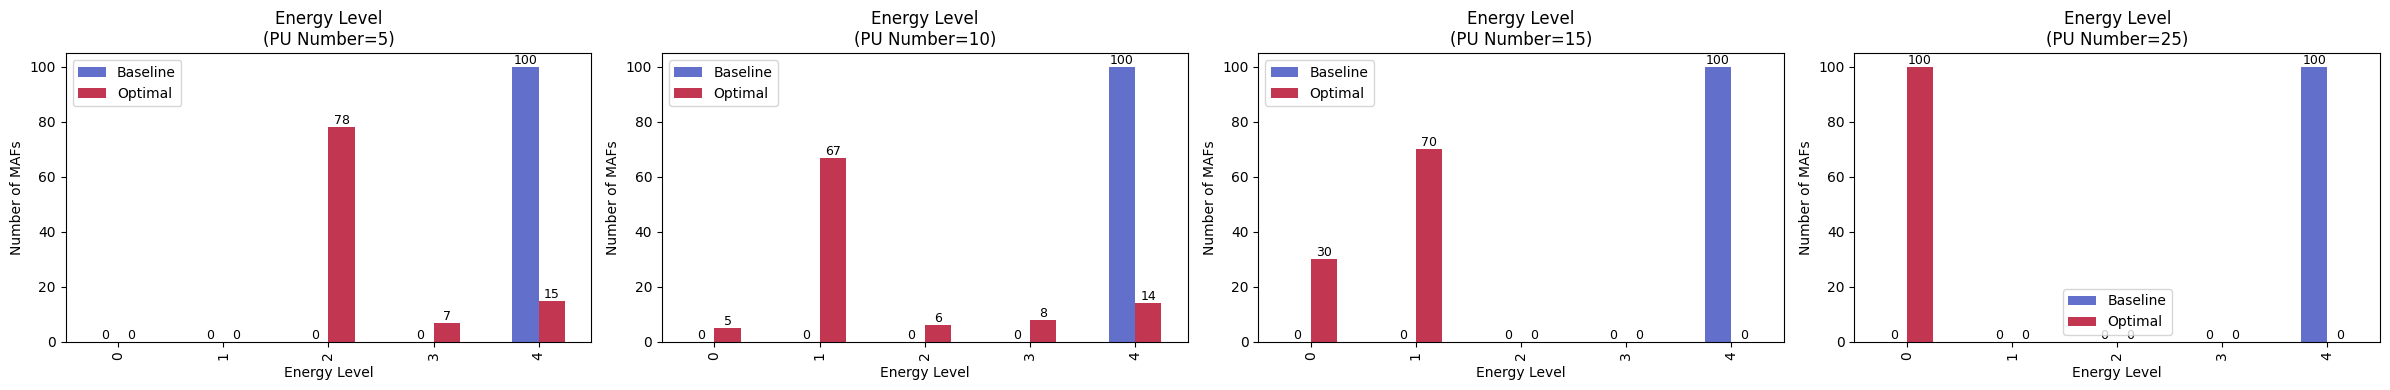

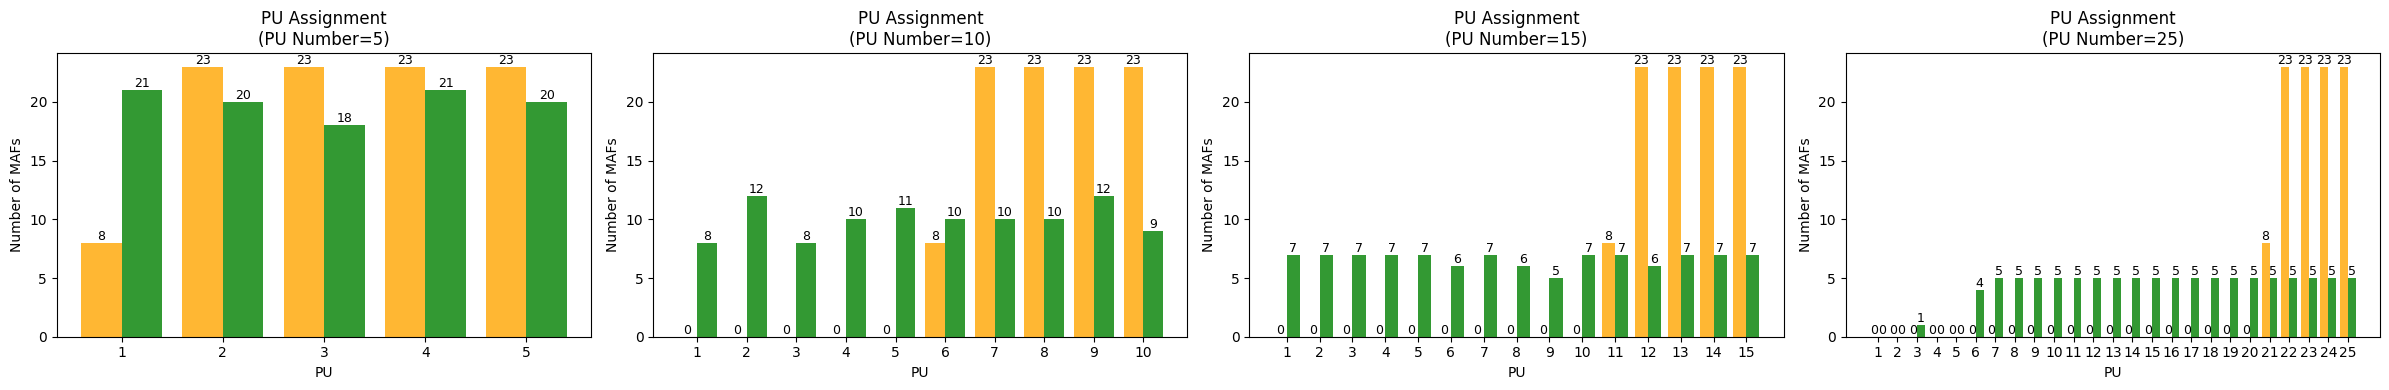

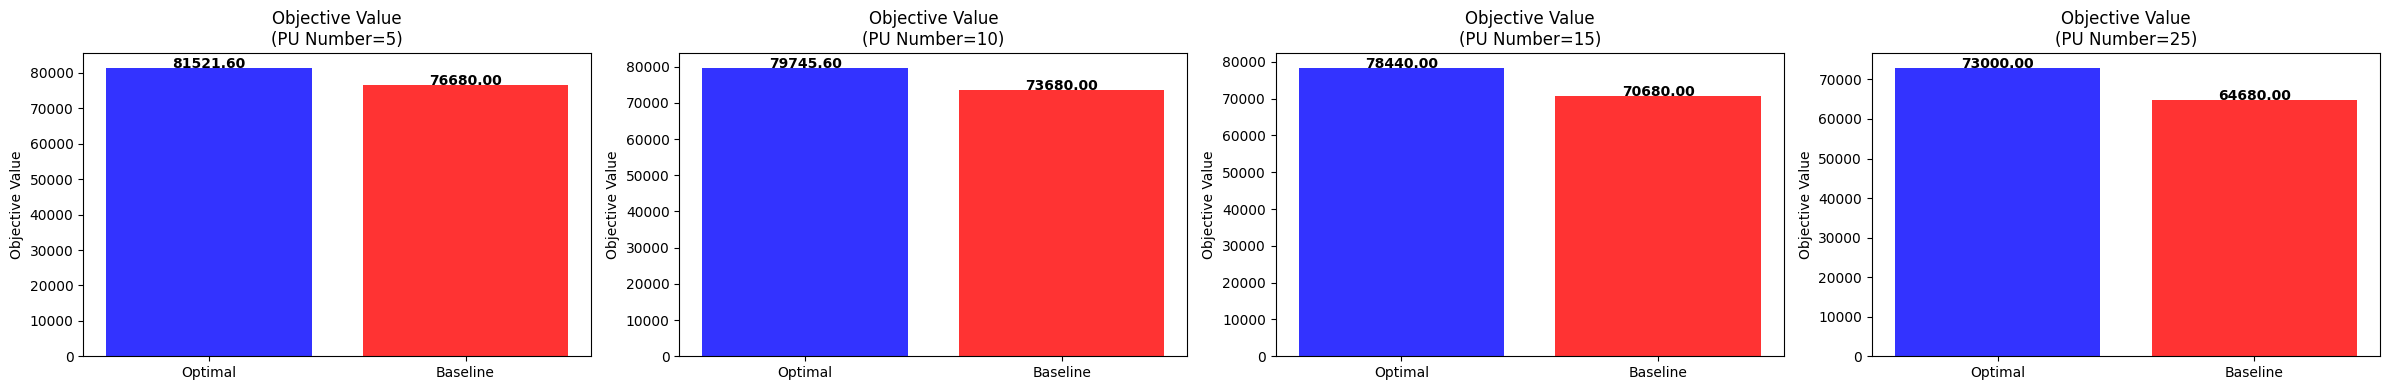

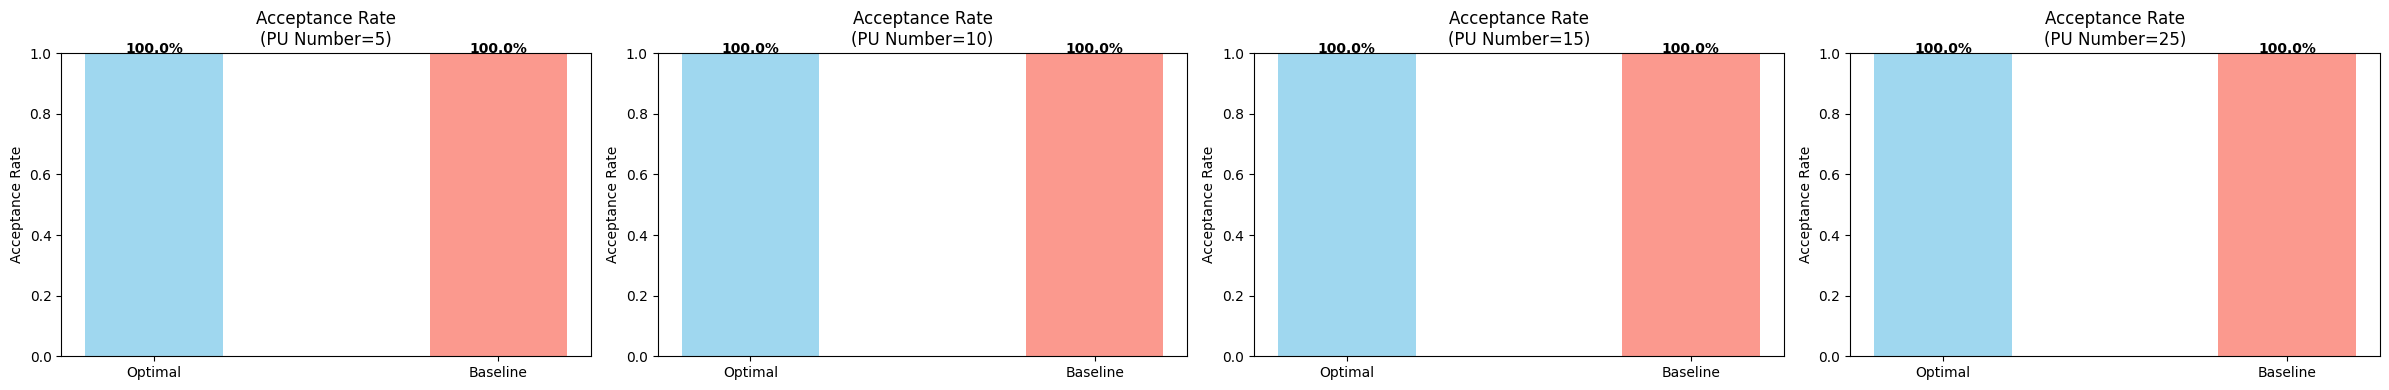

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


PU_numbers = [5, 10, 15, 25]
test_param_list = PU_numbers
test_param_name = "PU Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, param_value in enumerate(test_param_list):
    
    
    m = param_value  

   
    CPU_capacity = [1500] * m
    E_PU_max = [1000] * m
    P_idle = [2] * m
    P_max = [20] * m

    #  Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    #  Baseline 
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base


    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', fontsize=10, fontweight='bold')

    
  
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={param_value})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")


    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    max_pu_id = max(m, max(baseline_pu_assignments, default=0), max(optimal_pu_assignments, default=0))
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=max_pu_id + 1)[1:],
        "Optimal": np.bincount(optimal_pu_assignments, minlength=max_pu_id + 1)[1:]
    })
    bar_width = 0.4
    x = np.arange(1, max_pu_id + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={param_value})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(x)

    
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={param_value})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')


fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()

Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


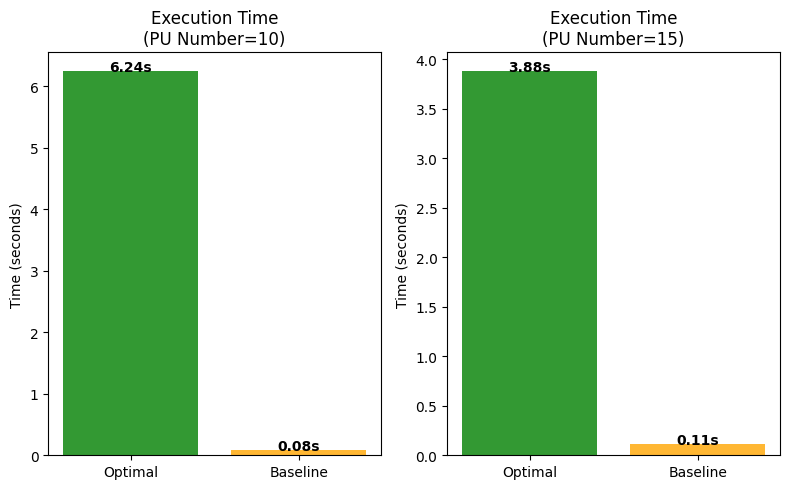

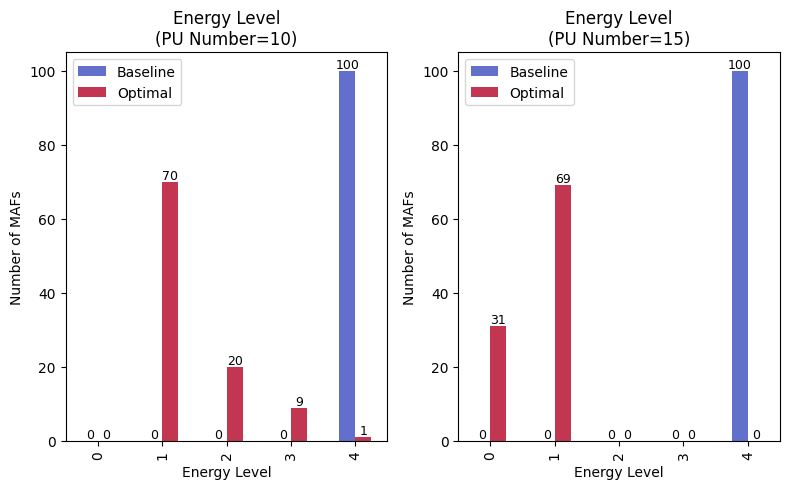

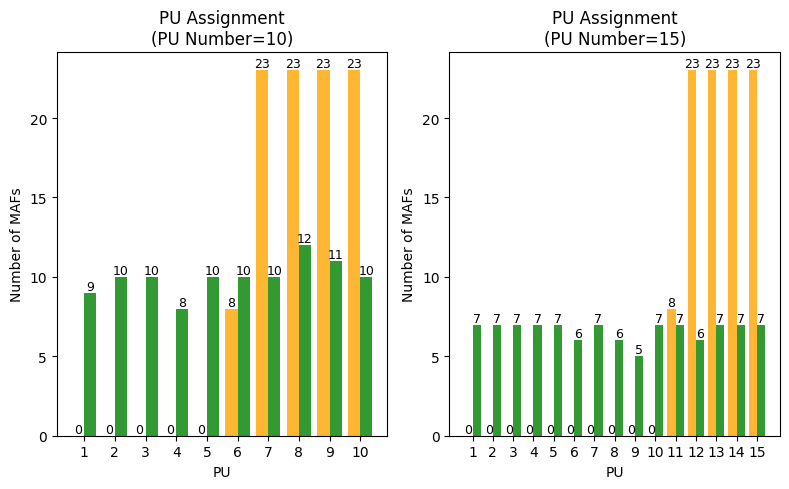

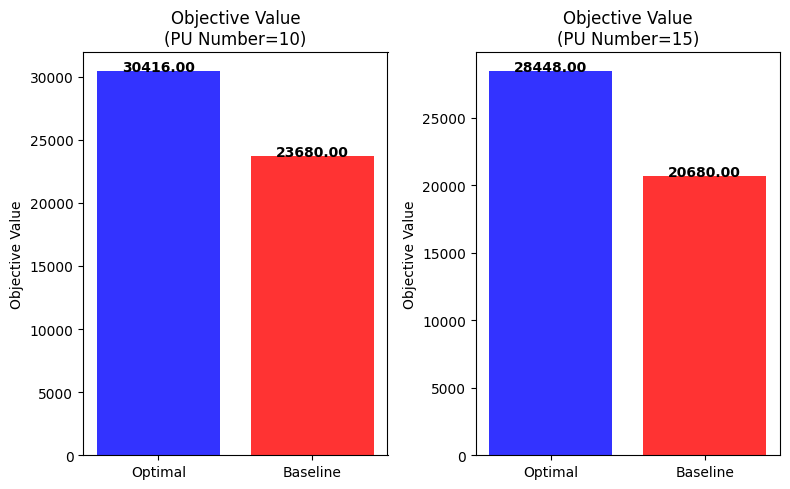

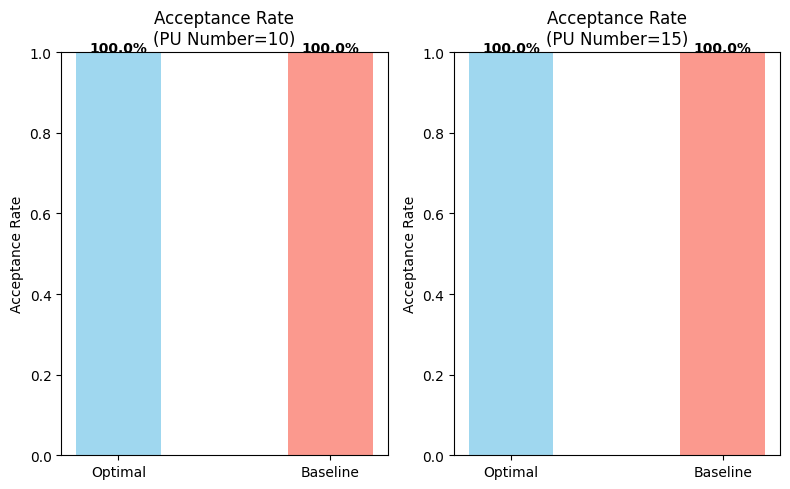

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


     


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


PU_numbers = [10,15]
test_param_list = PU_numbers
test_param_name = "PU Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(8, 5))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(8, 5))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(8, 5))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(8, 5))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(8, 5))

for idx, param_value in enumerate(test_param_list):
    
    
    m = param_value  

   
    CPU_capacity = [1500] * m
    E_PU_max = [1000] * m
    P_idle = [2] * m
    P_max = [20] * m

    #  Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(500, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    #  Baseline 
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(500, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base


    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', fontsize=10, fontweight='bold')

    
  
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={param_value})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")


    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    max_pu_id = max(m, max(baseline_pu_assignments, default=0), max(optimal_pu_assignments, default=0))
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=max_pu_id + 1)[1:],
        "Optimal": np.bincount(optimal_pu_assignments, minlength=max_pu_id + 1)[1:]
    })
    bar_width = 0.4
    x = np.arange(1, max_pu_id + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={param_value})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(x)

    
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={param_value})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')


fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()


